Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv', parse_dates=['SALE DATE'], index_col='SALE DATE')

In [3]:
## WRANGLE

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)


# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'



## My WRANGLE additions


# Take subset

mask1 = df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'
mask2 = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)

df = df[mask1 & mask2]

In [4]:
# See what else we need to do.

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         3151 non-null   object 
 1   NEIGHBORHOOD                    3151 non-null   object 
 2   BUILDING_CLASS_CATEGORY         3151 non-null   object 
 3   TAX_CLASS_AT_PRESENT            3151 non-null   object 
 4   BLOCK                           3151 non-null   int64  
 5   LOT                             3151 non-null   int64  
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING_CLASS_AT_PRESENT       3151 non-null   object 
 8   ADDRESS                         3151 non-null   object 
 9   APARTMENT_NUMBER                1 non-null      object 
 10  ZIP_CODE                        3151 non-null   float64
 11  RESIDENTIAL_UNITS               3151 non-null   float64
 12  COMMERCIAL_UNITS

In [5]:
# Drop useless columns

df = df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER', 'ADDRESS'])


# Convert other false-numerical columns to strings

df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)
df['TAX_CLASS_AT_TIME_OF_SALE'] = df['TAX_CLASS_AT_TIME_OF_SALE'].astype(str)


# LAND_SQUARE_FEET should be a number. I realized there were commas
# which were throwing it off.

df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',','').astype(float)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         3151 non-null   object 
 1   NEIGHBORHOOD                    3151 non-null   object 
 2   BUILDING_CLASS_CATEGORY         3151 non-null   object 
 3   TAX_CLASS_AT_PRESENT            3151 non-null   object 
 4   BLOCK                           3151 non-null   int64  
 5   LOT                             3151 non-null   int64  
 6   BUILDING_CLASS_AT_PRESENT       3151 non-null   object 
 7   ZIP_CODE                        3151 non-null   object 
 8   RESIDENTIAL_UNITS               3151 non-null   float64
 9   COMMERCIAL_UNITS                3151 non-null   float64
 10  TOTAL_UNITS                     3151 non-null   float64
 11  LAND_SQUARE_FEET                3151 non-null   float64
 12  GROSS_SQUARE_FEE

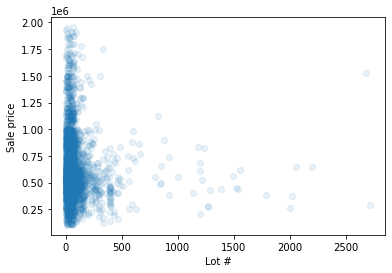

In [7]:
## Wasn't sure if LOT and BLOCK were supposed to be numerical, so
## I did some quick graphs.

plt.scatter(df['LOT'], df['SALE_PRICE'], alpha=.1)
plt.xlabel('Lot #')
plt.ylabel('Sale price')
plt.show()

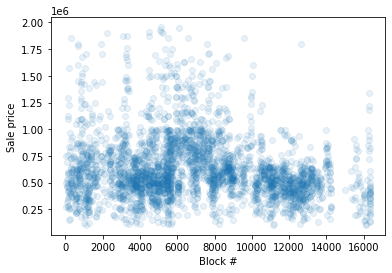

In [8]:
plt.scatter(df['BLOCK'], df['SALE_PRICE'], alpha=.1)
plt.xlabel('Block #')
plt.ylabel('Sale price')
plt.show()

In [9]:
## There seem to be some (very weak) relationships, so I'll keep
## them numerical.

In [10]:
## NOW split into features and target!

y = df['SALE_PRICE']
X = df.drop(columns='SALE_PRICE')

In [11]:
## Check for high cardinality in the cats

X.select_dtypes('object').nunique()

BOROUGH                             5
NEIGHBORHOOD                        6
BUILDING_CLASS_CATEGORY             1
TAX_CLASS_AT_PRESENT                2
BUILDING_CLASS_AT_PRESENT          13
ZIP_CODE                          125
TAX_CLASS_AT_TIME_OF_SALE           1
BUILDING_CLASS_AT_TIME_OF_SALE     11
dtype: int64

In [12]:
## ZIP_CODE is probably too high to be useful. Let's drop it. Also,
## BUILDING_CLASS_CATEGORY and TAX_CLASS_AT_TIME_OF_SALE are both 
## constant (only one unique value), so they contain no information.

X = X.drop(columns=['ZIP_CODE', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_TIME_OF_SALE'])

In [13]:
## Split into train and test sets

mask3 = df.index.month < 4

X_train, y_train = X[mask3], y[mask3]
X_test, y_test = X[~mask3], y[~mask3]

In [14]:
## One Hot our train set!

from category_encoders import OneHotEncoder

In [15]:
ohe = OneHotEncoder(use_cat_names=True)
XT_train = ohe.fit_transform(X_train)
XT_train.head()

c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,...,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
SALE DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2019-01-02,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
## Let's select the best features. I don't fully understand what the 
## first parameter is, but f_regression seemed to be commonly used.

from sklearn.feature_selection import SelectKBest, f_regression

In [17]:
## The reason I chose k=15 is because of the simple scree plot below,
## which clearly shows that we have just about all the information we
## need in the top 15 out of 45 features.

kbest = SelectKBest(f_regression, k=15)
kbest.fit(XT_train, y_train)
kbest.get_support()

array([ True, False,  True,  True, False,  True,  True, False,  True,
       False, False, False, False,  True, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False])

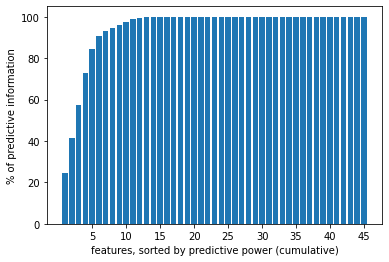

In [18]:
cumulative = np.cumsum(sorted(kbest.pvalues_, reverse=True))

plt.bar(x=range(1,46), height=cumulative/cumulative[-1]*100)
plt.xticks([5*x for x in range(1,10)])

plt.xlabel('features, sorted by predictive power (cumulative)')
plt.ylabel('% of predictive information')

plt.show()

In [19]:
## Now we can limit our training set by these top 15 features.

top_features = []

for is_top, feat in zip(kbest.get_support(), XT_train.columns):
    if is_top:
        top_features.append(feat)
        
XT_train_best = XT_train[top_features]
XT_train_best.head()

,BOROUGH_3,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FOREST HILLS,BLOCK,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A3,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A3
SALE DATE,,,,,,,,,,,,,,,
2019-01-01,1,0,0,1,0,0,5495,0,0,0.0,1.0,6800.0,1325.0,0,0
2019-01-01,0,0,0,1,0,0,7918,0,0,0.0,1.0,4000.0,2001.0,0,0
2019-01-02,0,1,0,1,0,0,4210,0,0,0.0,1.0,3500.0,2043.0,0,0
2019-01-02,1,0,0,1,0,0,5212,0,0,0.0,1.0,4000.0,2680.0,0,0
2019-01-02,1,0,0,1,0,0,7930,1,0,0.0,1.0,1710.0,1872.0,1,0


In [20]:
## Finally, let's One Hot encode our testing set so it matches up
## with the training set, as well as limit it to the same set of 
## top features. NOTE I will not perform SelectKBest again on the
## test set, for the results could be slightly different!

ohe = OneHotEncoder(use_cat_names=True)
XT_test = ohe.fit_transform(X_test)
XT_test_best = XT_test[top_features]

c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [21]:
## Model time

from sklearn.linear_model import Ridge

In [22]:
from sklearn.metrics import mean_absolute_error

In [23]:
model = Ridge(alpha=0, normalize=True)
model.fit(XT_train_best, y_train)

Ridge(alpha=0, normalize=True)

In [24]:
print('--R^2--')
print('Train:', model.score(XT_train_best, y_train))
print('Test:', model.score(XT_test_best, y_test))

--R^2--
Train: 0.44499930199468485
Test: 0.4188473149016986


In [25]:
print('--MAE--')
print('Train:', mean_absolute_error(y_train, model.predict(XT_train_best)))
print('Test:', mean_absolute_error(y_test, model.predict(XT_test_best)))

--MAE--
Train: 154278.9218999322
Test: 156322.71545930233
